## Load libraries

In [25]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import transforms

from ignite.engine import Events
from scripts.ignite import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import LinearCyclicalScheduler, CosineAnnealingScheduler

import random

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet, utils as enet_utils

from scripts.evaluate import eval_model
from scripts.transforms import gen_transform_train, gen_transform_validation
from scripts.plates_leak import apply_plates_leak

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls /storage

Model_efficientnet-b1_7.pth    diabetic-retinopathy-resized  rxrxai
aptos2019-blindness-detection  lost+found		     rxrxmodels
aptosplus		       retinopathy-train-2015


In [26]:
!ls /storage/rxrxai

pixel_stats.csv		       test.csv		  train.csv.zip
pixel_stats.csv.zip	       test.zip		  train.zip
recursion_dataset_license.pdf  test_controls.csv  train_controls.csv
sample_submission.csv	       train
test			       train.csv


In [27]:
path_data = '/storage/rxrxai'
device = 'cuda'
batch_size = 4
torch.manual_seed(0)
model_name = 'efficientnet-b4'
init_lr = 3e-4
end_lr = 1e-7

In [5]:
# dataframes for training, cross-validation, and testing
df = pd.read_csv(path_data+'/train.csv')
df_test = pd.read_csv(path_data+'/test.csv')
df_all = pd.concat([df, df_test])
df_pixels = pd.read_csv(path_data+'/pixel_stats.csv')

In [6]:
def train_or_test(row):
    return 'train' if not np.isnan(row['sirna']) else 'test'

df_all['ds'] = df_all.apply(train_or_test, axis=1)
df_all.head()

,experiment,id_code,plate,sirna,well,ds
0,HEPG2-01,HEPG2-01_1_B03,1,513.0,B03,train
1,HEPG2-01,HEPG2-01_1_B04,1,840.0,B04,train
2,HEPG2-01,HEPG2-01_1_B05,1,1020.0,B05,train
3,HEPG2-01,HEPG2-01_1_B06,1,254.0,B06,train
4,HEPG2-01,HEPG2-01_1_B07,1,144.0,B07,train


In [7]:
df_all['cell'] = df_all.apply(lambda row: row['experiment'].split("-")[0], axis=1)
df_all.head()

,experiment,id_code,plate,sirna,well,ds,cell
0,HEPG2-01,HEPG2-01_1_B03,1,513.0,B03,train,HEPG2
1,HEPG2-01,HEPG2-01_1_B04,1,840.0,B04,train,HEPG2
2,HEPG2-01,HEPG2-01_1_B05,1,1020.0,B05,train,HEPG2
3,HEPG2-01,HEPG2-01_1_B06,1,254.0,B06,train,HEPG2
4,HEPG2-01,HEPG2-01_1_B07,1,144.0,B07,train,HEPG2


In [8]:
df_all.tail()

,experiment,id_code,plate,sirna,well,ds,cell
19892,U2OS-05,U2OS-05_4_O19,4,NaN,O19,test,U2OS
19893,U2OS-05,U2OS-05_4_O20,4,NaN,O20,test,U2OS
19894,U2OS-05,U2OS-05_4_O21,4,NaN,O21,test,U2OS
19895,U2OS-05,U2OS-05_4_O22,4,NaN,O22,test,U2OS
19896,U2OS-05,U2OS-05_4_O23,4,NaN,O23,test,U2OS


In [9]:
train_length = len(df_all[df_all['ds'] == 'train'])

for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print(f"{cell} {df_all[df_all['ds'] == 'train'].groupby('cell').agg(['count'])[['experiment']].loc[cell][0] / train_length}")

HEPG2 0.21224154457072436
HUVEC 0.48440366972477067
RPE 0.21232370258797753
U2OS 0.09103108311652745


In [11]:
.01 * train_length

365.15000000000003

In [12]:
test_length = len(df_all[df_all['ds'] == 'test'])

for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print(f"{cell} {df_all[df_all['ds'] == 'test'].groupby('cell').agg(['count'])[['experiment']].loc[cell][0] / test_length}")

HEPG2 0.22259637131225812
HUVEC 0.4445896366286375
RPE 0.22199326531637936
U2OS 0.11082072674272503


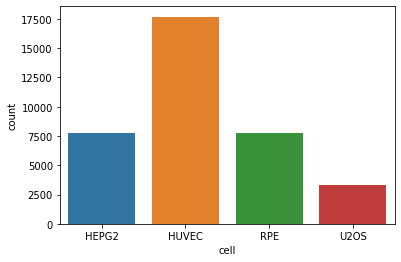

In [13]:
sns.countplot(x='cell',data=df_all[df_all['ds'] == 'train'])

In [14]:
df_all[df_all['ds'] == 'train'].groupby('cell').agg(['count'])

,experiment,id_code,plate,sirna,well,ds
,count,count,count,count,count,count
cell,,,,,,
HEPG2,7750,7750,7750,7750,7750,7750
HUVEC,17688,17688,17688,17688,17688,17688
RPE,7753,7753,7753,7753,7753,7753
U2OS,3324,3324,3324,3324,3324,3324


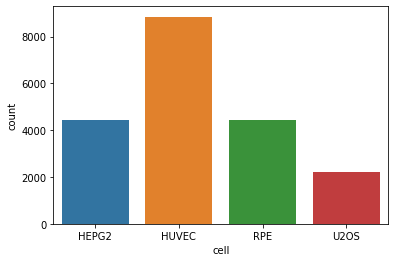

In [15]:
sns.countplot(x='cell',data=df_all[df_all['ds'] == 'test'])

In [16]:
df_all[df_all['ds'] == 'test'].groupby('cell').agg(['count'])

,experiment,id_code,plate,sirna,well,ds
,count,count,count,count,count,count
cell,,,,,,
HEPG2,4429,4429,4429,0,4429,4429
HUVEC,8846,8846,8846,0,8846,8846
RPE,4417,4417,4417,0,4417,4417
U2OS,2205,2205,2205,0,2205,2205


In [17]:
df_pixels.head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1,1,71.063782,43.146240,67.0,7,255
1,HEPG2-01_1_B02,HEPG2-01,1,B02,1,2,32.174431,9.384594,31.0,6,98
2,HEPG2-01_1_B02,HEPG2-01,1,B02,1,3,61.836025,23.377997,59.0,11,255
3,HEPG2-01_1_B02,HEPG2-01,1,B02,1,4,56.983257,16.011435,56.0,11,156
4,HEPG2-01_1_B02,HEPG2-01,1,B02,1,5,91.671993,39.221836,85.0,13,255


In [18]:
df_pixels[['min']].min()

min    0
dtype: int64

In [19]:
df_pixels[df_pixels['min'] == df_pixels[['min']].max()[0]].head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
289009,HUVEC-09_3_E02,HUVEC-09,3,E02,1,2,77.361301,18.421216,71.0,53,255


In [20]:
df_pixels[df_pixels['min'] == df_pixels[['min']].min()[0]].head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
44380,HEPG2-04_1_B04,HEPG2-04,1,B04,1,5,2.099361,2.016894,1.0,0,32
44386,HEPG2-04_1_B04,HEPG2-04,1,B04,2,5,2.907871,2.342452,2.0,0,33
44392,HEPG2-04_1_B05,HEPG2-04,1,B05,1,5,2.140354,2.482237,1.0,0,225
44398,HEPG2-04_1_B05,HEPG2-04,1,B05,2,5,3.846188,2.685085,4.0,0,28
44404,HEPG2-04_1_B06,HEPG2-04,1,B06,1,5,2.967934,2.221915,3.0,0,33


In [21]:
print(len(df))

36515


In [22]:
df_pixels.groupby('channel').agg(['count'])    

,id_code,experiment,plate,well,site,mean,std,median,min,max
,count,count,count,count,count,count,count,count,count,count
channel,,,,,,,,,,
1,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
2,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
3,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
4,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
5,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
6,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510


In [23]:
m = df_pixels[df_pixels['channel'] == 2]
m = m[m['experiment'].str.contains('HEPG2')]
m.tail()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
162535,HEPG2-11_4_O21,HEPG2-11,4,O21,2,2,23.061954,12.409125,21.0,2,112
162541,HEPG2-11_4_O22,HEPG2-11,4,O22,1,2,9.546902,9.937065,6.0,2,145
162547,HEPG2-11_4_O22,HEPG2-11,4,O22,2,2,9.051575,10.988752,4.0,2,220
162553,HEPG2-11_4_O23,HEPG2-11,4,O23,1,2,11.207123,12.421270,6.0,2,141
162559,HEPG2-11_4_O23,HEPG2-11,4,O23,2,2,11.352909,13.563623,6.0,1,168


In [24]:
for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print('\n\n')
    for channel in range(1,7):
        temp = df_pixels[df_pixels['channel'] == channel]
        temp = temp[temp['experiment'].str.contains(cell)]
        print(f'channel {channel} {cell} - mean: {temp[["mean"]].mean()[0]} | std: {temp[["std"]].mean()[0]}\n')




channel 1 HEPG2 - mean: 11.031356732537494 | std: 12.38342326316432

channel 2 HEPG2 - mean: 15.786221102312357 | std: 11.940651802029661

channel 3 HEPG2 - mean: 12.883933155952173 | std: 7.404890056698397

channel 4 HEPG2 - mean: 15.145480148271501 | std: 10.083671129382433

channel 5 HEPG2 - mean: 11.517225424319587 | std: 7.959842438990443

channel 6 HEPG2 - mean: 11.841935962489181 | std: 6.836244188216111




channel 1 HUVEC - mean: 4.333631709629353 | std: 5.168027755363951

channel 2 HUVEC - mean: 15.80156420876473 | std: 13.100209123833183

channel 3 HUVEC - mean: 7.1570779968701 | std: 3.7150705725246085

channel 4 HUVEC - mean: 8.393391375691078 | std: 6.873972929357963

channel 5 HUVEC - mean: 2.821444750663893 | std: 3.022117393519618

channel 6 HUVEC - mean: 6.563911710411285 | std: 3.3992237249709087




channel 1 RPE - mean: 2.6980435886108265 | std: 3.5158451986309567

channel 2 RPE - mean: 12.683445297258121 | std: 11.777622340405452

channel 3 RPE - mean: 12.57994

In [29]:
!cat /storage/rxrxai/sample_submission.csv

id_code,sirna
HEPG2-08_1_B03,911
HEPG2-08_1_B04,911
HEPG2-08_1_B05,911
HEPG2-08_1_B06,911
HEPG2-08_1_B07,911
HEPG2-08_1_B08,911
HEPG2-08_1_B09,911
HEPG2-08_1_B10,911
HEPG2-08_1_B11,911
HEPG2-08_1_B12,911
HEPG2-08_1_B13,911
HEPG2-08_1_B14,911
HEPG2-08_1_B15,911
HEPG2-08_1_B16,911
HEPG2-08_1_B17,911
HEPG2-08_1_B18,911
HEPG2-08_1_B19,911
HEPG2-08_1_B20,911
HEPG2-08_1_B21,911
HEPG2-08_1_B22,911
HEPG2-08_1_B23,911
HEPG2-08_1_C02,911
HEPG2-08_1_C04,911
HEPG2-08_1_C05,911
HEPG2-08_1_C06,911
HEPG2-08_1_C08,911
HEPG2-08_1_C09,911
HEPG2-08_1_C10,911
HEPG2-08_1_C12,911
HEPG2-08_1_C13,911
HEPG2-08_1_C14,911
HEPG2-08_1_C16,911
HEPG2-08_1_C17,911
HEPG2-08_1_C18,911
HEPG2-08_1_C20,911
HEPG2-08_1_C21,911
HEPG2-08_1_C23,911
HEPG2-08_1_D02,911
HEPG2-08_1_D03,911
HEPG2-08_1_D04,911
HEPG2-08_1_D05,911
HEPG2-08_1_D06,911
HEPG2-08_1_D07,911
HEPG2-08_1_D08,911
HEPG2-08_1_D09,911
HEPG2-08_1_D10,911
HEPG2-08_1_D11,911
HEPG2-08_1_D12,911
HEPG2-08_1_D13,911
HEPG2-08_1_D14,911
HEPG2-08_1_D15,911
HEPG2-08_1_D16,91

HUVEC-19_2_M14,911
HUVEC-19_2_M16,911
HUVEC-19_2_M17,911
HUVEC-19_2_M18,911
HUVEC-19_2_M20,911
HUVEC-19_2_M21,911
HUVEC-19_2_M23,911
HUVEC-19_2_N02,911
HUVEC-19_2_N03,911
HUVEC-19_2_N04,911
HUVEC-19_2_N05,911
HUVEC-19_2_N06,911
HUVEC-19_2_N07,911
HUVEC-19_2_N08,911
HUVEC-19_2_N09,911
HUVEC-19_2_N10,911
HUVEC-19_2_N11,911
HUVEC-19_2_N12,911
HUVEC-19_2_N13,911
HUVEC-19_2_N14,911
HUVEC-19_2_N15,911
HUVEC-19_2_N16,911
HUVEC-19_2_N17,911
HUVEC-19_2_N18,911
HUVEC-19_2_N19,911
HUVEC-19_2_N20,911
HUVEC-19_2_N21,911
HUVEC-19_2_N22,911
HUVEC-19_2_N23,911
HUVEC-19_2_O02,911
HUVEC-19_2_O03,911
HUVEC-19_2_O04,911
HUVEC-19_2_O05,911
HUVEC-19_2_O06,911
HUVEC-19_2_O07,911
HUVEC-19_2_O08,911
HUVEC-19_2_O09,911
HUVEC-19_2_O10,911
HUVEC-19_2_O11,911
HUVEC-19_2_O12,911
HUVEC-19_2_O13,911
HUVEC-19_2_O14,911
HUVEC-19_2_O15,911
HUVEC-19_2_O16,911
HUVEC-19_2_O17,911
HUVEC-19_2_O18,911
HUVEC-19_2_O19,911
HUVEC-19_2_O20,911
HUVEC-19_2_O21,911
HUVEC-19_2_O22,911
HUVEC-19_2_O23,911
HUVEC-19_3_B03,911
HUVEC-19_3_B

RPE-08_1_H23,911
RPE-08_1_I02,911
RPE-08_1_I03,911
RPE-08_1_I04,911
RPE-08_1_I05,911
RPE-08_1_I06,911
RPE-08_1_I07,911
RPE-08_1_I08,911
RPE-08_1_I09,911
RPE-08_1_I10,911
RPE-08_1_I11,911
RPE-08_1_I12,911
RPE-08_1_I13,911
RPE-08_1_I14,911
RPE-08_1_I15,911
RPE-08_1_I16,911
RPE-08_1_I17,911
RPE-08_1_I18,911
RPE-08_1_I19,911
RPE-08_1_I20,911
RPE-08_1_I21,911
RPE-08_1_I22,911
RPE-08_1_I23,911
RPE-08_1_J02,911
RPE-08_1_J04,911
RPE-08_1_J05,911
RPE-08_1_J06,911
RPE-08_1_J08,911
RPE-08_1_J09,911
RPE-08_1_J10,911
RPE-08_1_J12,911
RPE-08_1_J13,911
RPE-08_1_J14,911
RPE-08_1_J16,911
RPE-08_1_J17,911
RPE-08_1_J18,911
RPE-08_1_J20,911
RPE-08_1_J21,911
RPE-08_1_J23,911
RPE-08_1_K02,911
RPE-08_1_K03,911
RPE-08_1_K04,911
RPE-08_1_K05,911
RPE-08_1_K06,911
RPE-08_1_K07,911
RPE-08_1_K08,911
RPE-08_1_K09,911
RPE-08_1_K10,911
RPE-08_1_K11,911
RPE-08_1_K12,911
RPE-08_1_K13,911
RPE-08_1_K14,911
RPE-08_1_K15,911
RPE-08_1_K16,911
RPE-08_1_K17,911
RPE-08_1_K18,911
RPE-08_1_K19,911
RPE-08_1_K20,911
RPE-08_1_K21,9